In [1]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
import clawpack.petclaw as pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans


%matplotlib inline
%load_ext autoreload
%autoreload 2

# The purpose here is to test Dirichlet boundary conditions

In [2]:
filepath = '../Paper_3/flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def get_bathymetry(filepath, resolution=1):
    retval = collections.OrderedDict()
    z = []
    with open(filepath) as f:
        for line in f:
            values = line.split()
            if is_number(values[0])==False:
                if float(values[1]).is_integer():
                    retval[values[0]]=int(values[1])
                else:
                    retval[values[0]]=float(values[1])
            else:
                z.append(float(values[0]))
    z = np.array(z)
    print('Z: {0}'.format(len(z)))
    xmax = float(retval['nrows']) * retval['cellsize']
    nx = retval['nrows']
    dx = retval['cellsize']
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    x = np.linspace(0, nx*dx, num=len(z))
    f = interp1d(x, z)
    xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
    znew = f(xnew)
    nx = len(xnew)

    return znew,xnew

Z: 87
2019-04-15 03:52:30,515 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-15 03:52:31,217 INFO CLAW: Solution 1 computed for time t=13.333333
2019-04-15 03:52:32,054 INFO CLAW: Solution 2 computed for time t=26.666667
2019-04-15 03:52:32,904 INFO CLAW: Solution 3 computed for time t=40.000000
2019-04-15 03:52:33,792 INFO CLAW: Solution 4 computed for time t=53.333333
2019-04-15 03:52:34,679 INFO CLAW: Solution 5 computed for time t=66.666667
2019-04-15 03:52:35,609 INFO CLAW: Solution 6 computed for time t=80.000000
2019-04-15 03:52:36,561 INFO CLAW: Solution 7 computed for time t=93.333333
2019-04-15 03:52:37,543 INFO CLAW: Solution 8 computed for time t=106.666667
2019-04-15 03:52:38,534 INFO CLAW: Solution 9 computed for time t=120.000000
2019-04-15 03:52:39,466 INFO CLAW: Solution 10 computed for time t=133.333333
2019-04-15 03:52:40,384 INFO CLAW: Solution 11 computed for time t=146.666667
2019-04-15 03:52:41,325 INFO CLAW: Solution 12 computed for time t=160.000000

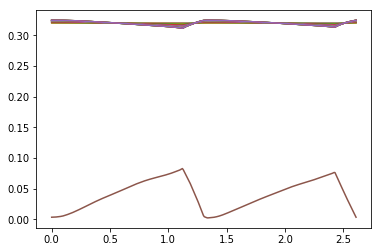

In [3]:

z,x = get_bathymetry(filepath,4)

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=10000)
sws.set_state_domain(x,z)
sws.set_mannings_source_term(mannings=0.025, slope=1.26/1000.)
sws.set_boundary_conditions()
sws.set_inital_conditions(0.32, 0.0)
sws.set_controller(tfinal=200., num_output_times=15)
sws.run()
cntrl = sws.get_controller()

for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + z
    plt.plot(x,surf)
plt.plot(x,z)

Z: 87
2019-04-15 03:58:51,335 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-15 03:58:57,021 INFO CLAW: Solution 1 computed for time t=100.000000
2019-04-15 03:59:03,338 INFO CLAW: Solution 2 computed for time t=200.000000
2019-04-15 03:59:08,971 INFO CLAW: Solution 3 computed for time t=300.000000


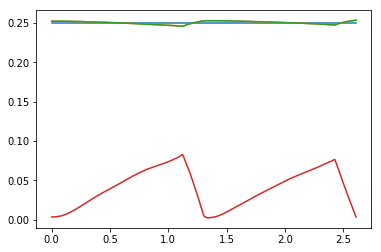

In [21]:



z,x = get_bathymetry(filepath,4)

sws = shallow_water_solver(kernel_language='Fortran')
sws.set_solver(max_steps=100000)
sws.set_state_domain(x,z)
sws.set_mannings_source_term(mannings=0.025, slope=1.26/1000.)

#sws.set_boundary_conditions()
hout = 0.25
Qin = 0.08

sws.set_Dirichlet_BC(hout,Qin)
sws.set_inital_conditions(hout, 0.0)
sws.set_controller(tfinal=300., num_output_times=3)
sws.run()
cntrl = sws.get_controller()

for i in range(cntrl.num_output_times):
    surf = cntrl.frames[i].q[0,:] + z
    plt.plot(x,surf)
plt.plot(x,z)

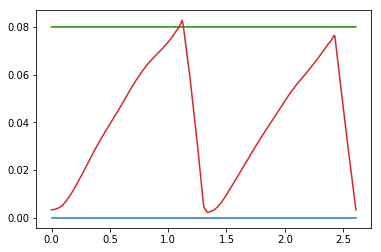

In [19]:
for i in range(cntrl.num_output_times):
    depth = cntrl.frames[i].q[0,:]
    u = cntrl.frames[i].q[1,:]
    plt.plot(x,u)
plt.plot(x,z)


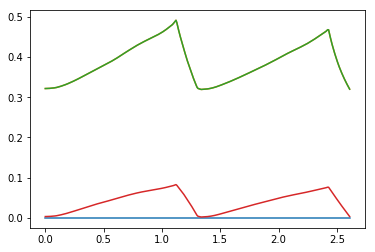

In [20]:
for i in range(cntrl.num_output_times):
    depth = cntrl.frames[i].q[0,:]
    u = cntrl.frames[i].q[1,:]/depth

    plt.plot(x,u)
plt.plot(x,z)